### Load libraries

In [1]:
import sys
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.apis

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

In [2]:
sys.path.append(str(GIT_ROOT))

from src.utils import runs_to_df

### Load data

In [3]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/adv-train",
    filters={"tags": {"$in": ["mnist20m"]}},
)

df_all = runs_to_df(runs)
df = df_all[df_all.state == "finished"]

In [4]:
print(sorted(df.n_train.unique()))

[1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 20000000]


### Plots

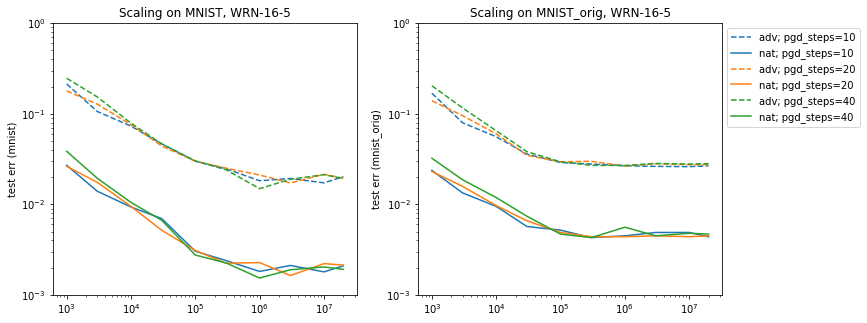

In [5]:
plt.figure(figsize=(12, 5))
for i, mnist_version in enumerate(["", "_orig"]):
    plt.subplot(1, 2, i + 1)

    filt = "depth == 16 & width == 5"
    for pgd_steps in sorted(df.pgd_steps.unique()):
        cdf = df.query(f"{filt} & pgd_steps == {pgd_steps}").sort_values("n_train")
        ax = plt.plot(
            cdf.n_train,
            1 - cdf[f"test{mnist_version}_acc_adv"],
            linestyle="--",
            label=f"adv; {pgd_steps=}",
        )
        plt.plot(
            cdf.n_train,
            1 - cdf[f"test{mnist_version}_acc_nat"],
            color=ax[0].get_color(),
            label=f"nat; {pgd_steps=}",
        )

    plt.ylim(1e-3, 1)
    plt.title(f"Scaling on MNIST{mnist_version}, WRN-16-5")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(f"test err (mnist{mnist_version})")
    if i == 1:
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

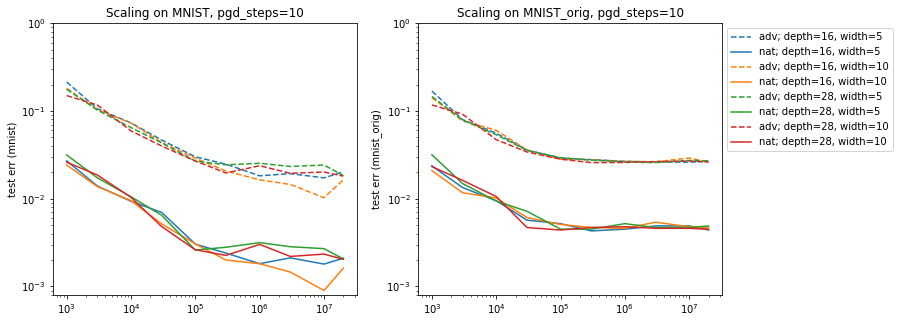

In [6]:
plt.figure(figsize=(12, 5))
for i, mnist_version in enumerate(["", "_orig"]):
    plt.subplot(1, 2, i + 1)

    filt = "pgd_steps == 10"
    for depth, width in sorted(
        tuple(_) for _ in df.query(filt)[["depth", "width"]].drop_duplicates().values
    ):
        cdf = df.query(f"{filt} & depth == {depth} & width == {width}").sort_values(
            "n_train"
        )
        ax = plt.plot(
            cdf.n_train,
            1 - cdf[f"test{mnist_version}_acc_adv"],
            linestyle="--",
            label=f"adv; {depth=}, {width=}",
        )
        plt.plot(
            cdf.n_train,
            1 - cdf[f"test{mnist_version}_acc_nat"],
            color=ax[0].get_color(),
            label=f"nat; {depth=}, {width=}",
        )

    plt.ylim(8e-4, 1)
    plt.title(f"Scaling on MNIST{mnist_version}, pgd_steps=10")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel(f"test err (mnist{mnist_version})")
    if i == 1:
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left")